In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GlobalMaxPool1D
import numpy as np
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords


In [2]:
num_of_words = 10000
data = pd.read_csv('Tweets.csv')
tweet_df = data[['text','airline_sentiment']]
tweet_df = tweet_df[tweet_df['airline_sentiment'] != 'neutral']
tweet = tweet_df['text'].values
tweet_df

,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive
...,...,...
14633,@AmericanAir my flight was Cancelled Flightled...,negative
14634,@AmericanAir right on cue with the delays👌,negative
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative


In [3]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder().fit_transform(tweet_df['airline_sentiment'])
#label = tf.keras.utils.to_categorical(label)

In [4]:
doc = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for sen in range(0, len(tweet)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(tweet[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization & remove Stopword
    document = document.split()
    
    swords = set(stopwords.words("english"))
    document = [w for w in document if w not in swords]

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    doc.append(document)
  

## fungsi word embedding

In [5]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(doc)

layer = tf.keras.layers.TextVectorization()
layer.adapt(doc)
vt = layer(doc).numpy()
vt[6]

array([ 48, 232, 403,   9, 242,  75,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int64)

In [7]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(vt, label, test_size=0.3, random_state=500) 
n_feature = X_train.shape[1] 
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) 
print(n_feature)

(8078, 26) (8078,) (3463, 26) (3463,)
26


In [8]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('data/wiki-news-300d-1M.vec', tokenizer.word_index, embedding_dim)

### check

In [9]:
vocab_size = len(tokenizer.word_index) + 1
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.710293867844403

In [10]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=n_feature))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
# weights=[embedding_matrix], trainable=False

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 50)            588700    
                                                                 
 dropout (Dropout)           (None, 26, 50)            0         
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 696,989
Trainable params: 696,989
Non-trai

In [12]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [13]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
253/253 [==============================] - 16s 55ms/step - loss: 0.5057 - accuracy: 0.7929 - precision: 0.4842 - recall: 0.0552 - val_loss: 0.5059 - val_accuracy: 0.7990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
253/253 [==============================] - 12s 49ms/step - loss: 0.5155 - accuracy: 0.7936 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5018 - val_accuracy: 0.7990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
253/253 [==============================] - 12s 48ms/step - loss: 0.5129 - accuracy: 0.7936 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5021 - val_accuracy: 0.7990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
253/253 [==============================] - 12s 48ms/step - loss: 0.5109 - accuracy: 0.7936 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5018 - val_accuracy: 0.7990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
253/253 [====================

Epoch 37/50
253/253 [==============================] - 12s 49ms/step - loss: 0.0127 - accuracy: 0.9957 - precision: 0.9898 - recall: 0.9892 - val_loss: 0.6578 - val_accuracy: 0.8963 - val_precision: 0.8047 - val_recall: 0.6394
Epoch 38/50
253/253 [==============================] - 13s 50ms/step - loss: 0.0167 - accuracy: 0.9938 - precision: 0.9868 - recall: 0.9832 - val_loss: 0.6977 - val_accuracy: 0.8952 - val_precision: 0.7656 - val_recall: 0.6897
Epoch 39/50
253/253 [==============================] - 13s 51ms/step - loss: 0.0141 - accuracy: 0.9959 - precision: 0.9916 - recall: 0.9886 - val_loss: 0.8157 - val_accuracy: 0.8972 - val_precision: 0.7681 - val_recall: 0.6997
Epoch 40/50
253/253 [==============================] - 14s 55ms/step - loss: 0.0129 - accuracy: 0.9957 - precision: 0.9875 - recall: 0.9916 - val_loss: 0.7915 - val_accuracy: 0.8966 - val_precision: 0.7807 - val_recall: 0.6753
Epoch 41/50
253/253 [==============================] - 16s 64ms/step - loss: 0.0104 - accura

In [14]:
loss, acc, prec, rec = model.evaluate(X_test, y_test, verbose=1)
f1 = 2*prec*rec/(prec+rec)
print('Accuracy: %.3f' % acc)
print('Loss: %.3f' % loss)
print('Precision: %.3f' % prec)
print('Recall: %.3f' % rec)
print('F1-Score: %.3f' % f1)

109/109 [==============================] - 2s 18ms/step - loss: 0.6810 - accuracy: 0.9024 - precision: 0.8003 - recall: 0.6853: 1s - loss: 0.6864 - accuracy: 0.9002 - precisi
Accuracy: 0.902
Loss: 0.681
Precision: 0.800
Recall: 0.685
F1-Score: 0.738


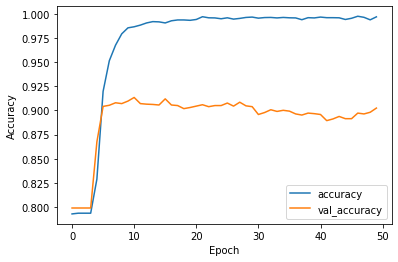

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim(0.6, 1.0)
plt.legend(loc='lower right')

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_encode(x):
    encoded_docs = tokenizer.texts_to_sequences(x)
    padded_sequence = pad_sequences(encoded_docs, maxlen=n_feature, padding='post')
    return padded_sequence

def get_encode2(x):
    vt = layer(x).numpy()
    padded_sequence = pad_sequences(vt, maxlen=n_feature, padding='post')
    return padded_sequence

In [32]:
x = ['bad sevice is terrible', 'good idea', 'its better food than before', 'right on cue with the delays']
x1 = ['its better food']
vec = get_encode2(x1)
pred = model.predict(vec)
print(np.amax(pred))

0.8185581


In [33]:
print("Bad" if np.amax(pred) < 0.5 else "Good")

Good
